<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/header.png" width="500"/>

## Goal of afternoon session

The goal of this session is to

> Excercise 1: Write your own convolutional layer from scratch.

> Excercise 2: Add batch normalisation and dropout to the `LeNet5` architecture shown in this morning's lecture, and train it to classify `FashionMNIST`.

> Excercise 3: Perform data augmentation and understand its effects.

> Excercise 4 (optional extension): interpret what the network has learned using the techniques from this morning's lecture.

In [3]:
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Excercise 1: Write your own convolutional layer from scratch

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/conv-definition.png" width="90%"/>

Given the image below, and **without using PyTorch**:
1) define two filters: a horizontal edge detector and a vertical edge detector ([see here for help on the filter weights](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm))
2) convolve these two filters with the image
3) plot the convolved output images
4) check your function matches `torch.nn.functional.conv2d`

In [4]:
response = requests.get("https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/camera.tif")
x = np.array(Image.open(BytesIO(response.content)), dtype=np.float32)
print(x.shape)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7b1300db23e0>

In [ ]:
fix, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(x)
plt.show()

In [ ]:
x.shape

In [5]:
x

NameError: name 'x' is not defined

In [20]:
x.max(), x.min()

(253.0, 7.0)

In [22]:
# TODO: define edge detector filters
w_h = np.array([[-1,0,1],
                [-2,0,2],
                [-1,0,1]], dtype=np.float32)
w_v = np.array([[-1,-2,-1],
                [0,0,0],
                [1,2,1]], dtype=np.float32)

def conv2d(x, w):
    """2D convolution.
    x: Input image of shape (height, width)
    w: Filter/kernel of shape (filter_height, filter_width)
    returns h: Output image
    """
    # TODO: define conv2d function

    #x = x/255 #normalising image between 0 and 1 (as currently it contains  8-bit unsigned integers, each pixel requires 1 byte of memory to store its value)

    height_x, width_x = x.shape
    height_w, width_w = w.shape

    height_output = height_x - height_w + 1
    width_output = width_x - width_w + 1

    output = np.zeros((height_output, width_output))

    for j in range(width_output):
      for i in range(height_output):
        region = x[i:i+height_w, j:j+width_w]
        output[i, j] = np.sum(region * w) # dot product

    return output


# TODO: plot the convolved output images
h_horizontal = conv2d(x, w_h)
h_vertical = conv2d(x, w_v)



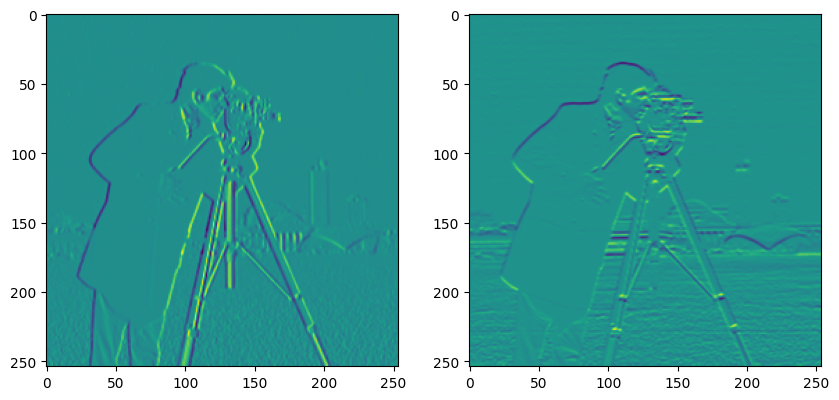

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].imshow(h_horizontal)
axes[1].imshow(h_vertical)

plt.show()

In [27]:
# TODO: check your function matches `torch.nn.functional.conv2d`
# we need to reshape arrays into batch_size, num channel, height, width
conv_h = torch.nn.functional.conv2d(torch.tensor(x).view(1,1,256,256), torch.tensor(w_h).view(1,1,3,3))
conv_v = torch.nn.functional.conv2d(torch.tensor(x).view(1,1,256,256), torch.tensor(w_v).view(1,1,3,3))

In [29]:
np.allclose(conv_h, h_horizontal), np.allclose(conv_v, h_vertical)

(True, True)

# Excercise 2: Add batch normalisation and dropout to the `LeNet5` architecture shown in this morning's lecture, and train it to classify `FashionMNIST`

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/lenet5.png" width="100%"/>

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

60000 images in training dataset
10000 images in test dataset


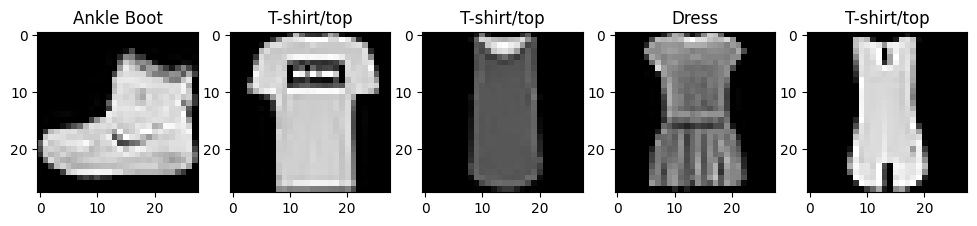

In [6]:
# download the FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(), #converts to tensor
    transforms.Normalize((0.5,), (0.5,)) #normalise the dataset
    ])
train_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./', train=False, download=True, transform=transform)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# plot some example images
print(f"{len(train_dataset)} images in training dataset")
print(f"{len(test_dataset)} images in test dataset")
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(classes[train_dataset[i][1]])
    plt.imshow(train_dataset[i][0][0], cmap="grey")
plt.show()

In [7]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [11]:
type(datasets.mnist.FashionMNIST)

type

1. First, train the same LeNet5 shown in this morning's lecture to classify the FashionMNIST dataset. Use the same hyperparameters (batch size, optimizer, learning rate etc) as the lecture.
2. Then, add batch normalisation and dropout after each convolutional layer. Retrain the network, and compare performance with the standard LeNet5.
3. What other changes you could make to the architecture / hyperparameters to improve performance?

In [27]:
class LeNet5(nn.Module):
    def __init__(self):
      super().__init__()
      self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
      self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
      self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.l5 = nn.Linear(in_features=16*5*5, out_features=10)
      self.log_softmax = torch.nn.LogSoftmax(dim=1)
      self.act = nn.ReLU()
    def forward(self, x):
      x = self.act(self.c1(x))
      x = self.act(self.s2(x))
      x = self.act(self.c3(x))
      x = self.act(self.s4(x))
      x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
      x = self.l5(x)
      x = self.log_softmax(x)
      return x

    def middle_feature(self, x):
      x = self.act(self.c1(x))
      x = self.act(self.s2(x))
      x = self.c3(x)
      return x

torch.manual_seed(123)
model = LeNet5()

y = model(train_dataset[0][0].unsqueeze(0))

In [28]:
model, y

(LeNet5(
   (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (l5): Linear(in_features=400, out_features=10, bias=True)
   (log_softmax): LogSoftmax(dim=1)
   (act): ReLU()
 ),
 tensor([[-2.1262, -2.3162, -2.3713, -2.5358, -2.3162, -2.2577, -2.3811, -2.3267,
          -2.4259, -2.0574]], grad_fn=<LogSoftmaxBackward0>))

In [29]:
def create_dataloaders(
        train_dataset,
        test_dataset,
        batch_size: int = 32,
        shuffle: bool = True,
        drop_last: bool = False
    ) -> Tuple[DataLoader, DataLoader]:
    """
    Creates DataLoaders for training and testing datasets.

    Args:
        train_dataset (Dataset): The training dataset.
        test_dataset (Dataset): The testing dataset.
        batch_size (int): Number of samples per batch. Default is 32.
        shuffle (bool): Whether to shuffle the training dataset. Default is True.
        drop_last (bool): Whether to drop the last incomplete batch. Default is False.

    Returns:
        Tuple[DataLoader, DataLoader]:
            - train_loader: DataLoader for the training dataset.
            - test_loader: DataLoader for the testing dataset.
    """
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,  # Shuffle only for training
        drop_last=drop_last  # Drop last batch if dataset size isn't divisible by batch_size
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,  # No shuffling for test/validation sets
        drop_last=False  # Keep all samples in test set
    )

    return train_loader, test_loader

In [30]:
train_loader, test_loader = create_dataloaders(train_dataset, test_dataset, batch_size=64)

In [32]:
# TODO: train the same LeNet5 shown in this morning's lecture to classify the FashionMNIST dataset.
# Use the same hyperparameters (batch size, optimizer, learning rate etc) as the lecture.
def train(
    model: nn.Module,               # The model to train
    train_loader: DataLoader,    # DataLoader for training data
    epochs: int = 1,             # Number of training epochs
    optimiser_class=optim.Adam,  # Optimizer class (e.g., Adam, SGD)
    optim_lr: float = 1e-3       # Learning rate for the optimizer
):
    """
    Trains the given model on the provided training data.

    Args:
        model (Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader providing the training dataset.
        epochs (int): Number of epochs for training. Default is 1.
        optimiser_class: Optimizer class (e.g., optim.Adam). Default is Adam.
        optim_lr (float): Learning rate for the optimizer. Default is 1e-3.
    """

    # Initialize the optimizer with the model's parameters and learning rate
    optimiser = optimiser_class(model.parameters(), lr=optim_lr)

    # Define the loss function: Negative Log-Likelihood Loss
    criterion = torch.nn.NLLLoss()

    # Set the model to training mode (important for layers like dropout, batch norm)
    model.train()

    # Loop over epochs
    for epoch in range(epochs):
        # Loop over batches in the training DataLoader
        for batch_idx, (data, target) in enumerate(train_loader):
            # Zero the parameter gradients to avoid accumulating gradients from previous steps
            optimiser.zero_grad()

            # Forward pass: Compute the model's output (log probabilities)
            logp = model(data) # this line implicitly calls the model’s forward method, passing data as its argument due to these lines of codes in nn.Module: def __call__(self, *input, **kwargs): result = self.forward(*input, **kwargs) return result

            # Compute the loss between the predicted log probabilities and true labels
            loss = criterion(logp, target)

            # Backward pass: Compute gradients with respect to the loss
            loss.backward()

            # Perform an optimization step to update model parameters
            optimiser.step()

            # Print training progress every 100 batches
            if batch_idx % 100 == 0:
                print(
                    f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                    f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}'
                )


# TODO: Add batch normalisation and dropout after each convolutional layer.
# Retrain the network, and compare performance with the standard LeNet5.

train(model, train_loader)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309611
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.756381
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.580015
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.562851
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.505438
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.519190
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.440453
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.465555
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.437228
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.390602


In [33]:
def evaluate(model: nn.Module, test_loader: DataLoader) -> float:
    """
    Evaluates the model on the test dataset and computes the accuracy.

    Args:
        model (Module): The PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset.

    Returns:
        float: The accuracy of the model on the test set as a percentage.
    """
    # Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)
    model.eval()

    # Containers for predictions and targets
    preds = []  # To store model predictions
    targets = []  # To store ground truth labels

    # Disable gradient calculations to save memory and speed up evaluation
    with torch.no_grad():
        # Iterate over the test dataset batches
        for data, target in test_loader:
            # Forward pass: Compute model predictions (log probabilities)
            logp = model(data)

            # Get the predicted class index (argmax of log probabilities)
            pred = logp.argmax(dim=1)

            # Append predictions and targets to respective lists
            preds.append(pred)
            targets.append(target)

    # Concatenate all batched predictions and targets into single tensors
    preds = torch.cat(preds)
    targets = torch.cat(targets)

    # Compute the number of correct predictions
    correct = preds.eq(targets).sum().item()

    # Calculate accuracy as a percentage
    accuracy = 100.0 * correct / len(test_loader.dataset)

    # Print evaluation results
    print(f'\nTest set: Average Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    # Return the accuracy
    return accuracy


plt.figure()
ConfusionMatrixDisplay.from_predictions(targets, preds, ax=plt.gca(), colorbar=False, cmap='bone_r')
plt.show()

evaluate(model, test_loader)


NameError: name 'Module' is not defined

# Excercise 3: Perform data augmentation and understand its effects

Using data augmentation can help improve the accuracy of the model and reduce the likelihood of overfitting.

We can easily perform data augmentations by using PyTorch **[transforms](https://pytorch.org/vision/stable/transforms.html#v1-api-reference)** in our training `Dataset` class.

Tasks:
1. Add a transform to `train_dataset` which randomly rotates training images by 10 degrees below ([hint](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)), and plot some images to check the rotation is being applied
2. Retrain your models with this transformation. What differences do you observe?
3. Try adding other transformations too (e.g. random cropping, flipping, and gaussian blur)

In [ ]:
# TODO: Add a transform to `train_dataset` which randomly rotates training images by 10 degrees below,
# and plot some images to check the rotation is being applied


# TODO: Retrain your models with this transformation. What differences do you observe?


# TODO: Try adding other transformations too (e.g. random cropping, flipping, and gaussian blur)


# Excercise 4 (optional extension): interpret what the network has learned using the techniques from this morning's lecture

Select a test image, and then plot 1) the feature maps (outputs) of the first convolutional layer and 2) the saliency of the image to its class prediction.

In [ ]:
# TODO: Select a test image, and then plot
# 1) the feature maps (outputs) of the first convolutional layer and
# 2) the saliency of the image to its class prediction

